# Итоговое задание

## Адилов Марсель РИ-491223. Вариант 9

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import h5py
from statsmodels.tsa import api as tsa
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.tsa.arima_model import ARIMA 
%matplotlib inline
import tensorflow as tf
import keras
import pywt
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import plot_model

## Просмотрим все варианты

Можно выбрать 1, 9, 13, 20, 21

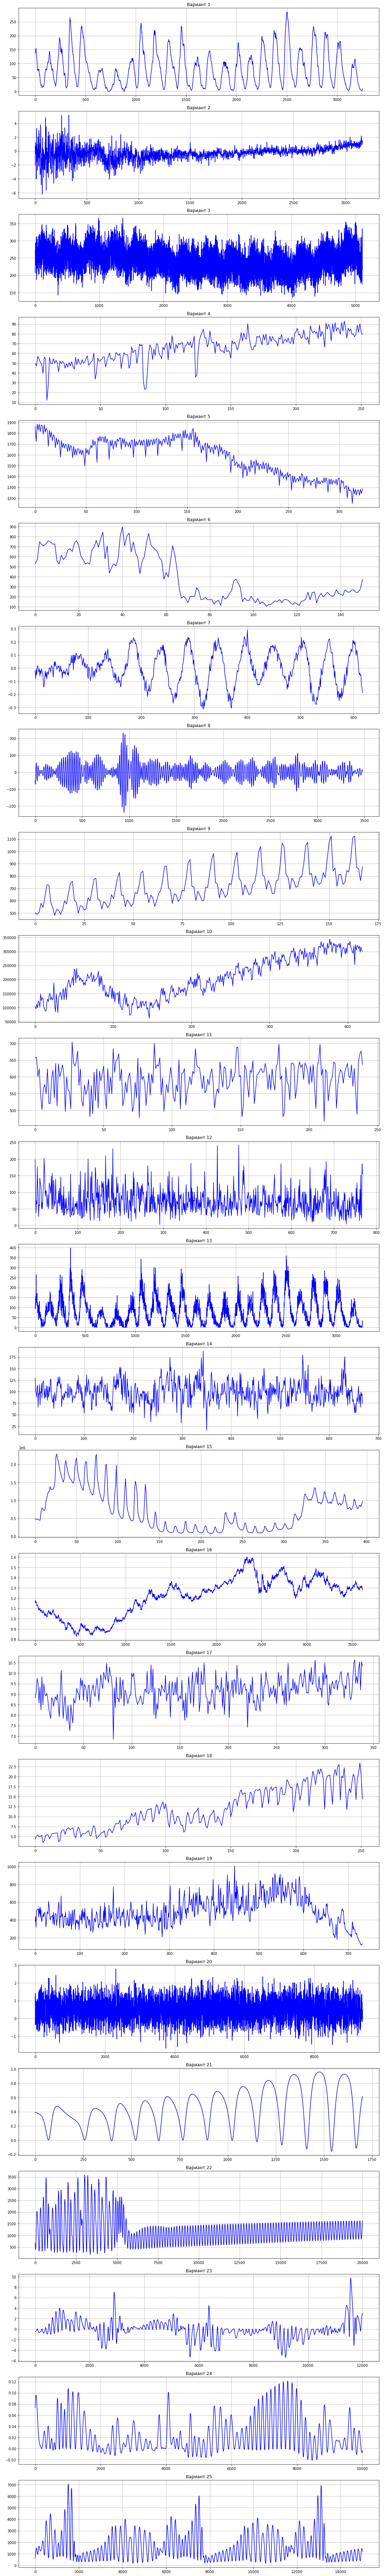

In [18]:
fig, ax = plt.subplots(25, figsize = (15, 100))

for i in range (25):
    data = np.loadtxt(f'/Users/marseladilov/Documents/_The university/4th course/8th semester/Методы прогнозирования данных/Итоговое задание/Data2022/{i+1}.txt') 
    Fort = np.array(data)
    ax[i].plot(Fort, 'b')
    ax[i].set_title(f'Вариант {i+1}')
    ax[i].grid()

plt.tight_layout() # корректирует параметры подзаголовка (чтобы не было наложения на другие графики)

## Выбираем вариант 9

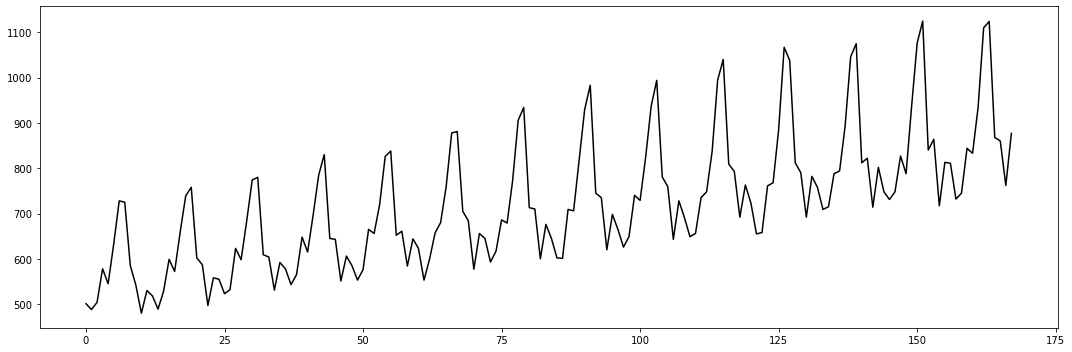

In [2]:
data = np.loadtxt('/Users/marseladilov/Documents/_The university/4th course/8th semester/Методы прогнозирования данных/Итоговое задание/Data2022/\
9.txt') 
Fort = np.array(data)
plt.figure(figsize = (15, 5)) 
plt.plot(Fort, 'k') 
plt.tight_layout()
plt.show()

### Мат ожидание и дисперсия ряда

In [10]:
print('Мат ожидание: ', np.mean(Fort))
print('Дисперсия: ', np.var(Fort))

Мат ожидание:  722.297619047619
Дисперсия:  20229.863803854878


### Периодограмма и спектрограмма

Оценим его периодограмму и оценку спектральной плотности мощности ряда с помощью метода Велша (Welch)

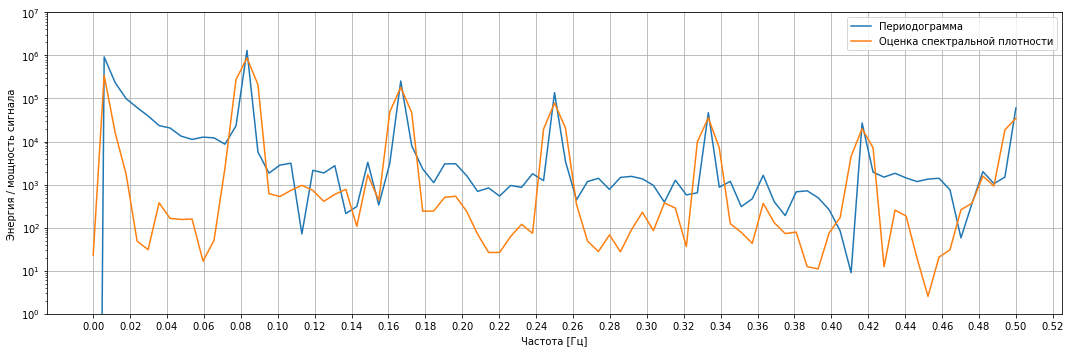

In [129]:
from scipy import signal
pd1, pdden1 = signal.periodogram(Fort)
pdw1, pddenw1 = signal.welch(Fort, nperseg = len(Fort))
plt.figure(figsize = (15, 5)) 
plt.xticks(np.arange(0, 0.6, 0.02)) # Установка более частого отсчета оси x
plt.grid()
plt.ylim(10**0, 10**7)
plt.semilogy(pd1, pdden1, label = 'Периодограмма') 
plt.semilogy(pdw1, pddenw1, label = 'Оценка спектральной плотности')
plt.ylabel('Энергия / мощность сигнала')
plt.xlabel('Частота [Гц]')
plt.tight_layout()
plt.legend()

По периодограмме мы видим преобладание частот примерно 0.005, 0.0825, 0.1675, 0.25, 0.3325, 0.415, 0.5 Гц. Посчитаем среднюю разницу между частотами, после чего с помощью нее найдем пероид:

In [131]:
def average_difference(lst):
    differences = [lst[i+1] - lst[i] for i in range(len(lst)-1)]
    avg_diff = sum(differences) / len(differences)
    return avg_diff

values = [0.005, 0.0825, 0.1675, 0.25, 0.3325, 0.415, 0.5]
avg_diff = average_difference(values)
print('Средняя разница между частотами: ', avg_diff)
print('Пероид: ', 1/avg_diff)

Средняя разница между частотами:  0.0825
Пероид:  12.121212121212121


<ipython-input-69-deae0a3abccf>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx, f, Sxx)
<ipython-input-69-deae0a3abccf>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx, f, Sxx, cmap='gray_r') # в оттенках серого цвета


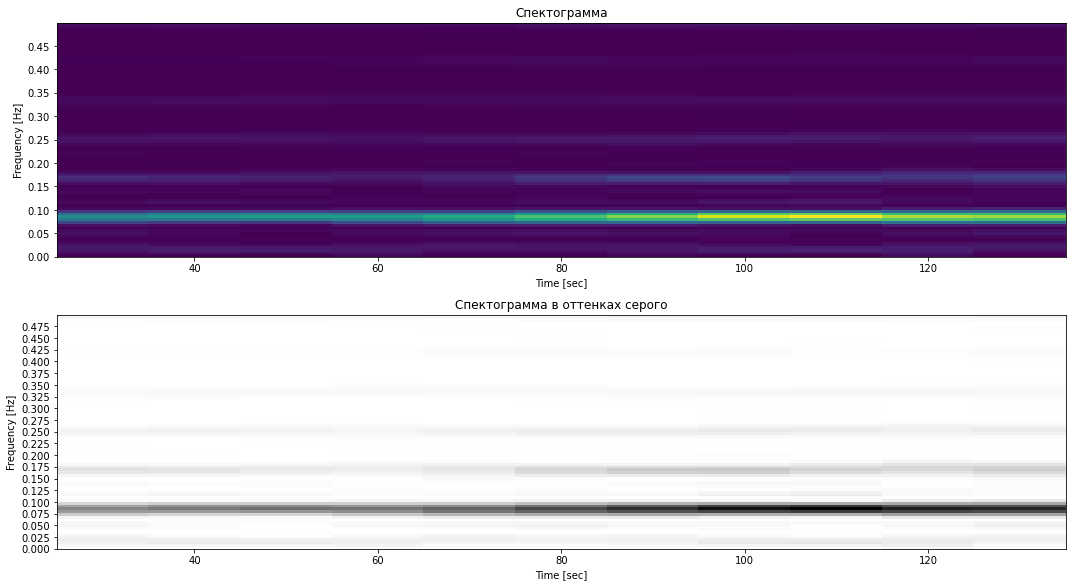

In [69]:
t = np.arange(len(Fort))
fs = 1/(t[1]-t[0]) # частота дискретизации
f, tx, Sxx = signal.spectrogram(Fort, fs, nperseg = 50, noverlap = 40, nfft=len(Fort))
# длина каждого сегмента = 21, число пересекающихся точек между сегментами = 18, длина FFT = 168
plt.figure(figsize = (15, 20))
plt.subplot(5,1,1)
plt.title('Спектограмма')
plt.pcolormesh(tx, f, Sxx)
plt.yticks(np.arange(0, 0.5, 0.05)) # Установка более частого отсчета оси y
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 0.5) # строим до 0.5 Гц
plt.xlabel('Time [sec]')
plt.subplot(5,1,2)
plt.title('Спектограмма в оттенках серого')
plt.pcolormesh(tx, f, Sxx, cmap='gray_r') # в оттенках серого цвета 
plt.yticks(np.arange(0, 0.5, 0.025)) # Установка более частого отсчета оси y
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 0.5)
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()

Как видно из спектограммы, график постепенно увеличивает амплитуду вплоть до 110 отсчета, после чего амплитуда вновь спадает. ВР ряд имеет лишь одну основную частоту 0.085 Гц, однако также виднеются другие с частотой примерно 0.015, 0.165, 0.250, 0.330, 0.420 Гц

### Тренд, его прогноз и доверительные интервалы

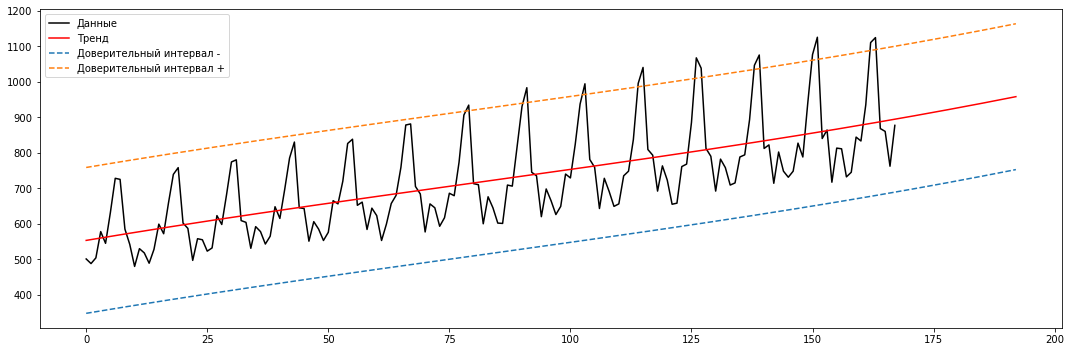

In [34]:
F = Fort
fc = 25 # количество точек прогноза

t=np.arange(0, len(F), 1) # диапазон ряда
t=t.reshape(-1,1)
t0=np.arange(0, len(F)+fc, 1) # диапазон прогноза 
t0=t0.reshape(-1,1)

bb = np.polyfit(t.reshape(1,-1)[0], F.reshape(1,-1)[0], 3)
p = np.poly1d(bb) # создаем экземпляр полинома 
trend = p(t0)

# расчет доверительных интервалов
sum1 = 0 
    
for i in range(len(Fort)):
    sum1 += (trend[i] - Fort[i])**2
    
d = len(trend)*[0]
for i in range(len(trend)):
    d[i] = 1.96 * np.sqrt(sum1/len(Fort))

plt.figure(figsize = (15, 5))
plt.plot(t, F, 'k', label = 'Данные')
plt.plot(t0, trend, 'r', label = 'Тренд') # полином на прогнозной временной сетке 
plt.plot(t0, trend-d, '--', label = 'Доверительный интервал -') 
plt.plot(t0, trend+d, '--', label = 'Доверительный интервал +') 
plt.legend()
plt.tight_layout()
plt.show()

## ARIMA

In [4]:
F_cut = Fort[:-25]

arima = ARIMA(F_cut, order = (9, 1, 8)) # 811, 812, 815, 910, 911, 912, 918, 919
model_fit = arima.fit(disp = False) # подгоняем под ВР
print(model_fit.summary())

/Users/marseladilov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/marseladilov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed,

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  142
Model:                 ARIMA(9, 1, 8)   Log Likelihood                -688.120
Method:                       css-mle   S.D. of innovations             25.474
Date:                Sat, 20 May 2023   AIC                           1414.240
Time:                        16:43:18   BIC                           1470.401
Sample:                             1   HQIC                          1437.061
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9057        nan        nan        nan         nan         nan
ar.L1.D.y      0.2634   3.59e-06   7.35e+04      0.000       0.263       0.263
ar.L2.D.y     -0.2296   2.77e-06  -8.28e+04      0.0

/Users/marseladilov/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


<Figure size 432x288 with 0 Axes>

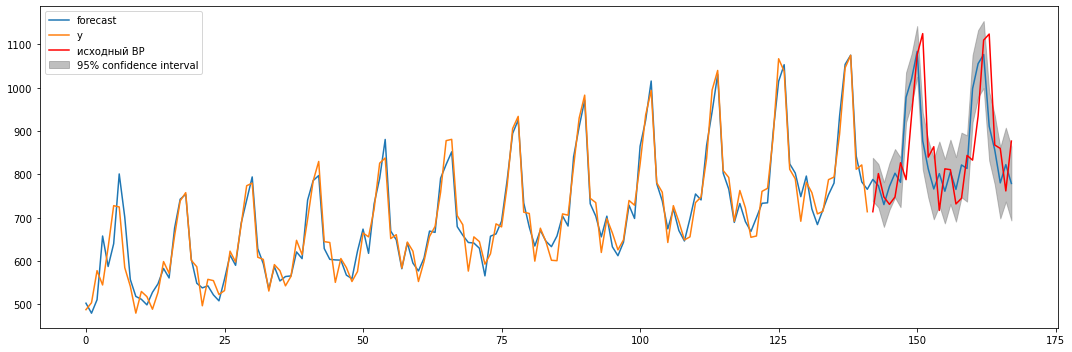

In [5]:
t = np.arange(len(Fort))
trend_ARIMA = model_fit.predict(start=len(F_cut), end=len(Fort)) # прогнозные значения по модели АРПСС
figure = plt.figure()
figure = model_fit.plot_predict(1, len(Fort))
figure.set_size_inches(15, 5)
plt.plot(t[-26:], Fort[-26:], 'r', label='исходный ВР') # исходный ВР
plt.legend()
plt.tight_layout()
plt.show()

#### Оценки прогноза

In [6]:
def afe(Z, trend):
    sum = 0
    for i in range(len(Z)):
        sum += abs(Z[i]- trend[i])
    sum = sum/len(Z)
    return sum

def skvo(Z, trend):
    sum = 0
    for i in range(len(Z)):
        sum += (Z[i]- trend[i])**2
    sum = np.sqrt(sum/len(Z))
    return sum

def soa(Z, trend):
    sum = 0
    #print('len(Z):', len(Z))
    for i in range(len(Z)):
        sum += abs(trend[i]-Z[i])/trend[i]
        #sum += abs((trend[i]-Z[i])/trend[i])
        #print('Z[i]:', Z[i], '\ttrend[i]:', trend[i], '\tsum:', sum)
    sum = sum/len(Z)*100
    #print('Final sum:', sum)
    return sum

print('СКВО прогноза ARIMA', skvo(Fort[-25:], trend_ARIMA))
print('Средняя ошибка прогноза ARIMA', afe(Fort[-25:], trend_ARIMA))
print('Средняя ошибка аппроксимации прогноза ARIMA', soa(Fort[-25:], trend_ARIMA))

СКВО прогноза ARIMA 865.3486476649264
Средняя ошибка прогноза ARIMA 856.3307663180302
Средняя ошибка аппроксимации прогноза ARIMA -316.21016387630834


## Выделение периодик
### Вейвлет

/Users/marseladilov/opt/anaconda3/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


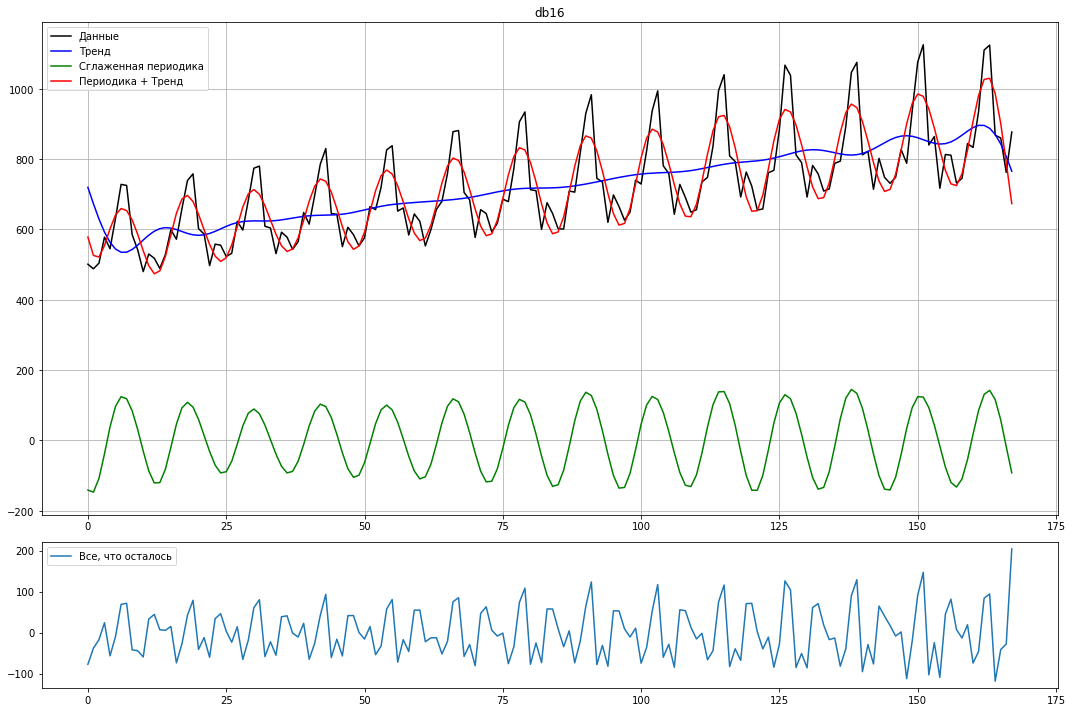

In [75]:
wvlt_base = ['dmey', 'db8', 'coif3', 'haar', 'sym4', 'coif1', 'db4', 'db2', 'sym5',
            'coif5', 'haar', 'sym6', 'db6', 'sym7', 'db10', 'sym8', 'db5',
            'coif4', 'sym10', 'db16', 'haar', 'db20', 'sym16', 'coif2', 'db18']
number = 19
wvlt = pywt.Wavelet(wvlt_base[number]) # выбор базового вейвлета
cA3, cD3, cD2, cD1 = pywt.wavedec(Fort, wvlt, mode='periodization', level=3) 
Fw1 = pywt.waverec((cA3, None, None, None), wvlt, mode='periodization')
Fw2 = pywt.waverec((None, cD3, None, None), wvlt, mode='periodization')
Fw3 = pywt.waverec((cA3, cD3, None, None), wvlt, mode='periodization')
Fw4 = pywt.waverec((None, cD2, cD1), wvlt, mode='periodization')

plt.figure(figsize = (15, 10))
plt.subplot(4,1,(1,3))
plt.plot(Fort, 'k', label='Данные')
plt.plot(Fw1, 'b', label='Тренд')
plt.plot(Fw2, 'g', label='Сглаженная периодика')
plt.plot(Fw3, 'r', ls='-', label='Периодика + Тренд')
plt.grid()
plt.legend()
plt.title(f'{wvlt_base[number]}')
plt.tight_layout()

plt.subplot(4,1,4)
plt.plot(Fw4, ls='-', label='Все, что осталось')
plt.legend()
plt.tight_layout()

plt.show()

### SSA

In [161]:
def SSA_modes(F, L):
    N = len(F)
    K=N-L+1
    X = np.empty((L, K))
    for i in range(L):
        for j in range(K):
            X[i][j] = F[j+i]
    #print('\nX =\n', X)
    S = np.dot(X, X.T) # полная матрица
    U, A, _ = np.linalg.svd(S) # U – матрица собственных векторов, A – массив собственных чисел
    V = np.dot(X.T, U) # V - матрица траекторных векторов
    return A, U, V

In [162]:
def SSA_group(A, U, V, N, I):
    L = len(A)
    K = N - L +1
    V = V.transpose()
    Z = np.dot(U[:, I], V[I, :])
    
    G = np.zeros(N)
    L_1 = min(L,K)
    K_1 = max(L,K)
    
    for k in range(0, L_1 - 1):
        sum = 0
        for m in range(0, k+1):
            sum += Z[m, k-m]
        G[k] = (1/(k+1))*sum
        
    for k in range(L_1-1, K_1):
        sum = 0
        for m in range(0, L_1-1+1):
            sum += Z[m, k-m]
        G[k] = (1/L_1)*sum
    
    for k in range(K_1, N+1-1):
        sum = 0
        for m in range(k-K_1+1, N-K_1+1):
            sum += Z[m, k-m]
        G[k] = (1/(N-k))*sum
    
    return G

#### Разложение

На графике мы видим, что с течением времени амплитуда колебаний понемногу возрастает, а тренд линейно устремляется вверх. Период примерно равен 14. 

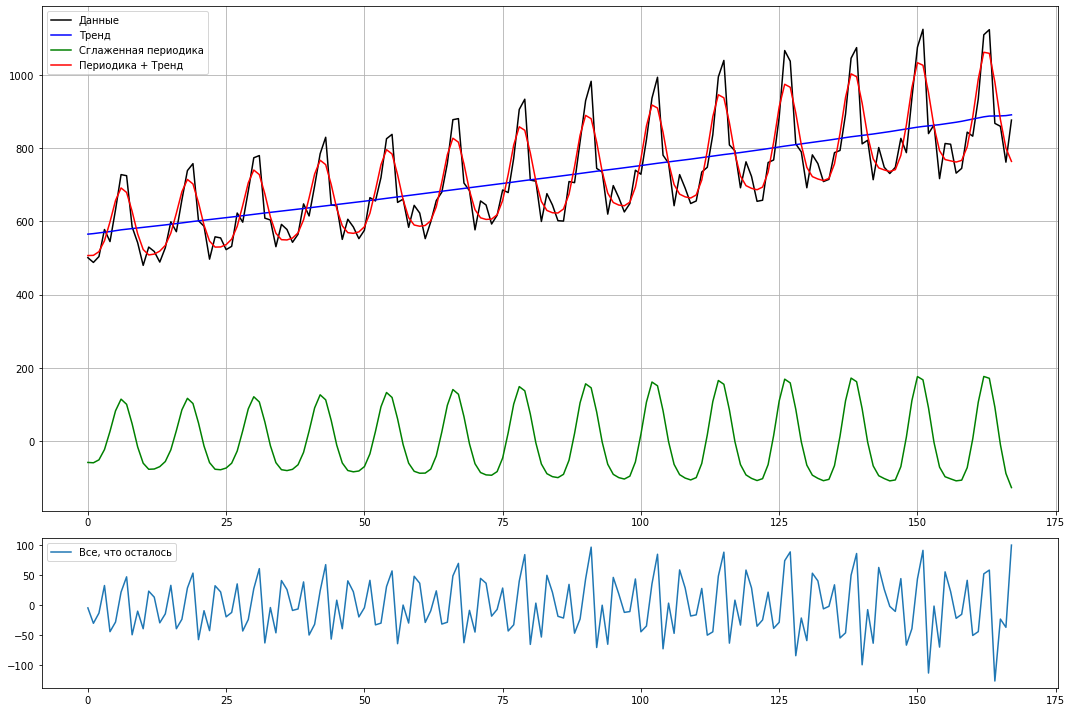

In [163]:
A, U, V = SSA_modes(Fort, 50) # разложение с длиной окна 200
F1 = SSA_group(A, U, V, len(Fort), [0])
F2 = SSA_group(A, U, V, len(Fort), [1, 2, 3])
F3 = SSA_group(A, U, V, len(Fort), [0, 1, 2, 3])
F4 = SSA_group(A, U, V, len(Fort), [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
plt.figure(figsize = (15, 10))
plt.subplot(4,1,(1,3))
plt.plot(Fort, 'k', label='Данные')
plt.plot(F1, 'b', label='Тренд')
plt.plot(F2, 'g', label='Сглаженная периодика')
plt.plot(F3, 'r', ls='-', label='Периодика + Тренд')
plt.grid()
plt.legend()

plt.subplot(4,1,4)
plt.plot(F4, ls='-', label='Все, что осталось')
plt.legend()

plt.tight_layout()
plt.show()

## Прогноз SSA-R

In [120]:
def SSA_forecast(F, L, I, M):
    A, U, V = SSA_modes(F, L) # разложение с длиной окна L
    vu = np.linalg.norm(U[-1, I]) # норма последнего вектора из матрицы U
    N = len(F)
    
    # ряд весовых коэффициентов
    R = np.sum(U[L - 1, I] * U[0:L - 1, I], 1)
    R = R / (1 - vu * vu)
    
    G = SSA_group(A, U, V, N, I)
    Q = np.zeros(N+M)
    #print('len Q', len(Q))
    #print('len G', len(G))
    #print('len A', len(A))
    
    for i in range(N):
        Q[i] = G[i]
        #print('Q[', i, '] =', Q[i])
        
    for i in range(N, N+M):
        sum = 0
        for j in range(L-1):
            sum += R[j]*Q[i-j-1]
        Q[i] = sum
        #print('new Q[', i, '] =', Q[i])
    
    return Q   

#### Ретроспективный прогноз (25 точек)

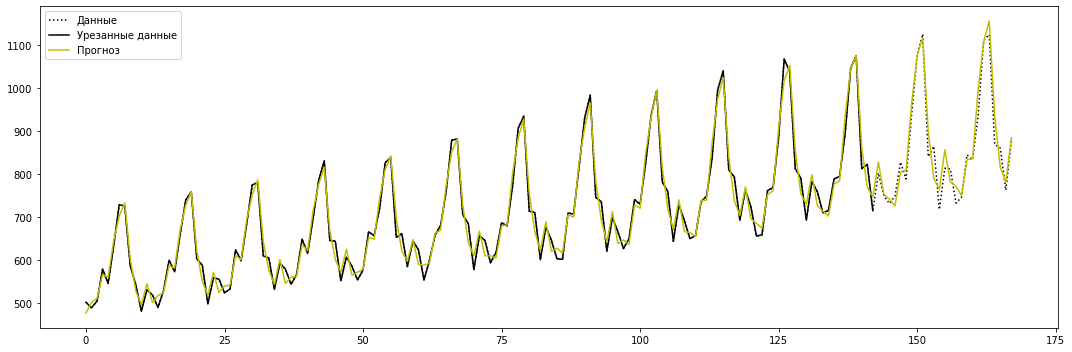

In [122]:
F_cut = Fort[:-25]

plt.figure(figsize = (15, 5)) 
plt.plot(Fort, c ='k', ls=':', label = 'Данные')
plt.plot(F_cut, c ='k', label = 'Урезанные данные')
plt.plot(SSA_forecast(F_cut, 24, [0, 1, 2, 3, 4, 5, 6, 7], 25), 'y', label = 'Прогноз')
plt.legend()
plt.tight_layout()
plt.show()

#### Прогноз на 50 точек вперед

С такими же параметрами, как и в ретроспективном, так как результат у предыдущего неплох. Возьмем окно размером 24 и восстановим по группе [0, 1, 2, 3, 4, 5, 6, 7]

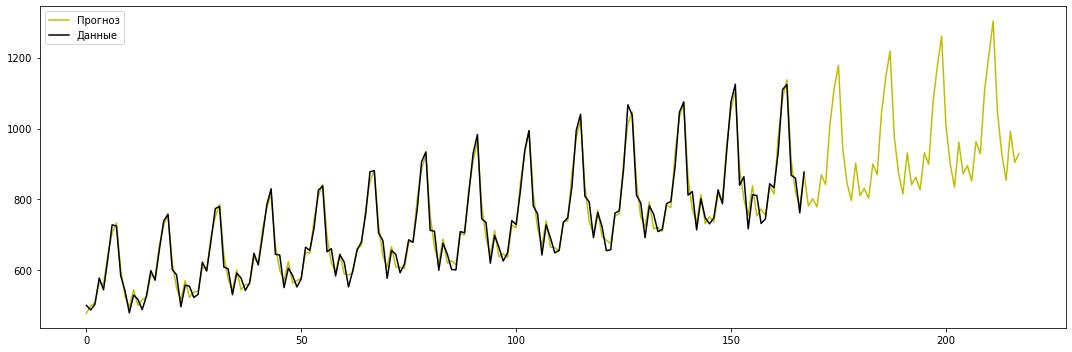

In [123]:
plt.figure(figsize = (15, 5))
plt.plot(SSA_forecast(Fort, 24, [0, 1, 2, 3, 4, 5, 6, 7], 50), 'y', label = 'Прогноз')
plt.plot(Fort, 'k', label = 'Данные')
plt.tight_layout()
plt.legend()

## Прогноз LSTM
Делим данные на тестовую и тренировочную часть

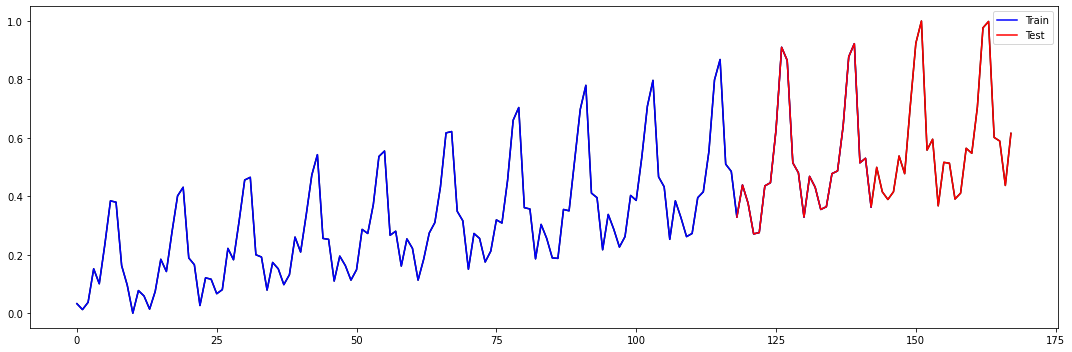

In [222]:
len_F = len(Fort)
fc = 25 # прогноз на 25 точек
obs = 25 # прогноз 1 точки по _ прошлым

F = Fort
F = F.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1)) 
F = scaler.fit_transform(F)
F_tr = F[:len_F-fc]
F_test = F[len_F-fc-obs:]
plt.figure(figsize = (15, 5)) 
plt.plot(F, 'k') 
plt.plot(np.r_[:len_F-fc],F_tr, 'b', label = 'Train') 
plt.plot(np.r_[len_F-fc-obs:len_F],F_test, 'r', label = 'Test') 
plt.legend()
plt.tight_layout()
plt.show()

In [223]:
data_gen = TimeseriesGenerator(F_tr, F_tr, length=obs, sampling_rate=1, batch_size=len_F-fc)

batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # точки обучения, прогноз 1 точки по _ прошлым 
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

(118, 25, 1)
(118, 1, 25)
(118, 1)


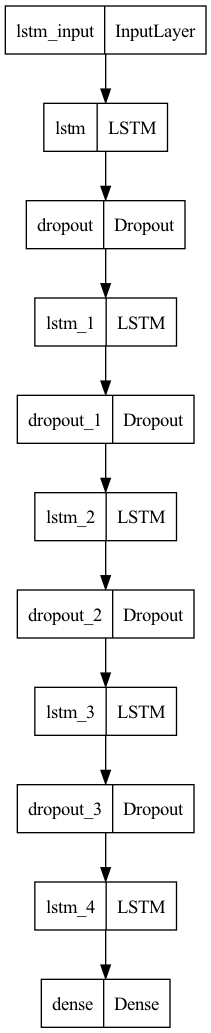

In [224]:
keras.backend.clear_session() 
model = Sequential()
model.add(LSTM(units=40, return_sequences=True, input_shape=(1, obs))) # units нейронов 
model.add(Dropout(0.3)) 
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40))
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
plot_model(model, to_file='model.png')

In [225]:
model.fit(xx, yy, epochs = 140) # 140 эпох
model.save('lstm_model_1.h5')

Epoch 1/140
4/4 [==============================] - 6s 7ms/step - loss: 0.1764
Epoch 2/140
4/4 [==============================] - 0s 8ms/step - loss: 0.1663
Epoch 3/140
4/4 [==============================] - 0s 7ms/step - loss: 0.1554
Epoch 4/140
4/4 [==============================] - 0s 9ms/step - loss: 0.1435
Epoch 5/140
4/4 [==============================] - 0s 8ms/step - loss: 0.1309
Epoch 6/140
4/4 [==============================] - 0s 9ms/step - loss: 0.1170
Epoch 7/140
4/4 [==============================] - 0s 8ms/step - loss: 0.1000
Epoch 8/140
4/4 [==============================] - 0s 7ms/step - loss: 0.0807
Epoch 9/140
4/4 [==============================] - 0s 8ms/step - loss: 0.0594
Epoch 10/140
4/4 [==============================] - 0s 6ms/step - loss: 0.0390
Epoch 11/140
4/4 [==============================] - 0s 5ms/step - loss: 0.0281
Epoch 12/140
4/4 [==============================] - 0s 6ms/step - loss: 0.0368
Epoch 13/140
4/4 [==============================] - 0s 7ms/st

In [226]:
from keras.models import load_model
# load model from single file
model = load_model('lstm_model_1.h5')

#### Train and test predict

(118, 25, 1)
(118, 1, 25)
(118, 1)
4/4 [==============================] - 2s 3ms/step
(25, 1, 25)
(25, 1)
1/1 [==============================] - 0s 16ms/step


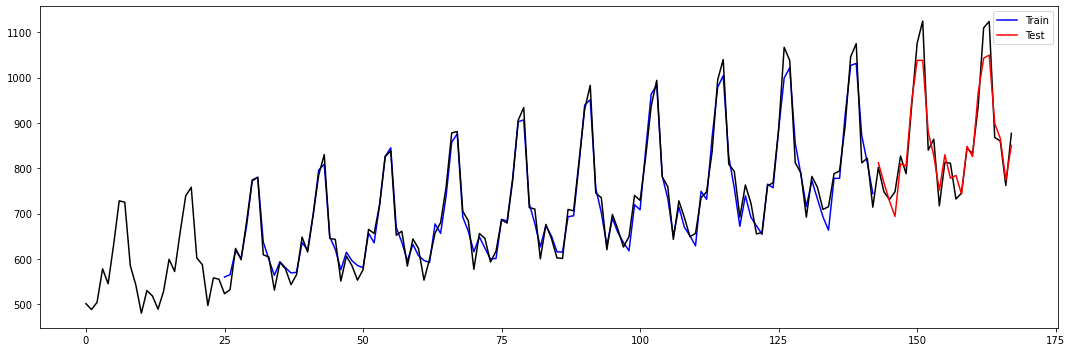

In [227]:
# Train predict
data_gen = TimeseriesGenerator(F_tr, F_tr, length=obs, sampling_rate=1, batch_size=len_F-fc)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # точки обучения, прогноз 1 точки по _ прошлым 
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict) 
plt.figure(figsize = (15, 5))
plt.plot(np.r_[obs:len_F-fc], trainPredict, 'b', label = 'Train')

# Test predict
data_gen = TimeseriesGenerator(F_test, F_test, length=obs, sampling_rate=1, batch_size=len_F-fc-obs) 
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

testPredict = model.predict(xx)
testPredict = scaler.inverse_transform(testPredict) 

plt.plot(Fort, 'k')
plt.plot(np.r_[len_F-fc:len_F], testPredict, 'r', label = 'Test')
plt.legend()
plt.tight_layout()
plt.show()

#### Продлеваем прогноз за грань тестовой части

In [228]:
F_test_new = Fort
F_test_new = F_test_new.reshape(-1, 1) 
F_test_new = scaler.transform(F_test_new)
data_gen = TimeseriesGenerator(F_test_new, F_test_new, length=obs, sampling_rate=1, batch_size=obs, start_index=len(F_test_new)-obs-1) 
batch_0 = data_gen[0]
x, y = batch_0
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy = y
print(xx.shape) # прогноз на 1 точку по obs наблюдениям 
print(yy.shape) #

(1, 1, 25)
(1, 1)


1/1 [==============================] - 0s 16ms/step


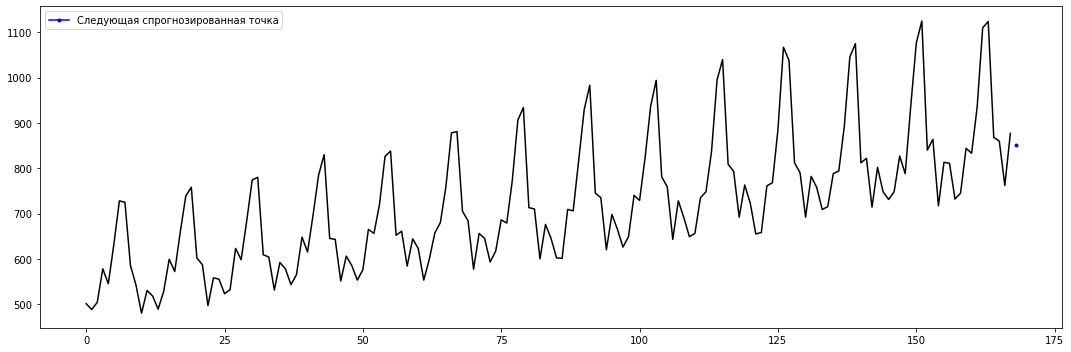

Следующая спрогнозированная точка [[850.50806]]


In [229]:
Predict = model.predict(xx)
Predict = scaler.inverse_transform(Predict) 
plt.figure(figsize = (15, 5))
plt.plot(Fort, 'k') 
plt.plot(np.r_[len_F:len_F+xx.shape[0]], Predict, 'b', marker = '.', label = 'Следующая спрогнозированная точка')
plt.legend()
plt.tight_layout()
plt.show()
print('Следующая спрогнозированная точка', Predict)

##
## спрогнозировал одну точку вперед, сделать это в цикле (с момента F_test_new)
##

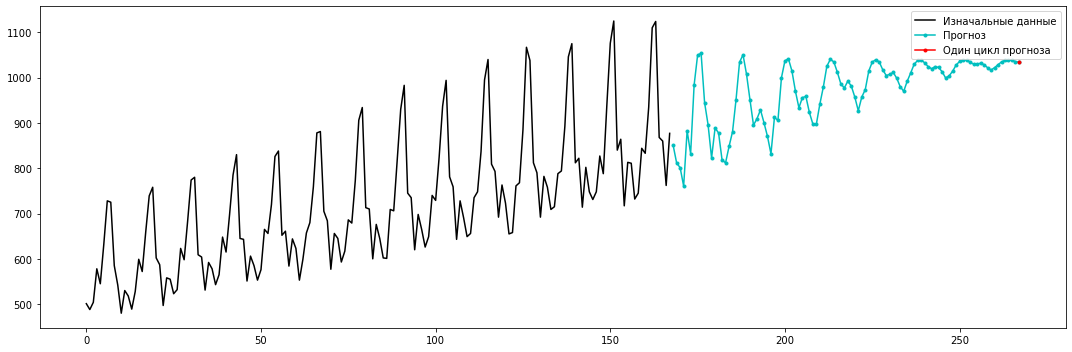

In [234]:
data = Fort
data = data.reshape(-1, 1) 
data = scaler.fit_transform(data)
for i in range(100): # прогноз на _ точек
    data_gen = TimeseriesGenerator(data, data, length=obs, sampling_rate=1, batch_size=len(data)-1, start_index=len(data)-obs-1) 
    batch_0 = data_gen[0]
    x, y = batch_0
    xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
    yy = y
    Predict = model.predict(xx, verbose=0)
    data = np.append(data, Predict)

t1 = np.arange(len(Fort), len(data))
data = data.reshape(-1, 1)
data = scaler.inverse_transform(data)
Predict = scaler.inverse_transform(Predict) 
plt.figure(figsize = (15, 5))
plt.plot(Fort, 'k', label = 'Изначальные данные') 
plt.plot(t1, data[len(Fort):], 'c', marker = '.', label = 'Прогноз') 
plt.plot(t1[-1], Predict, 'r', marker = '.', label = 'Один цикл прогноза')
plt.legend()
plt.tight_layout()
plt.show()

##
## (Исправлено) проблема со start_index, он статичен, хотя правильно сделать len(F_test_new)-13, но так не работает
##
## (Исправлено) также не влияет количество циклов (длина прогноза), всегда 10 точек. Решено, это выводился Predict, а нужно смотреть на F_test_new
##
## Идея:        подавать не весь отрезок данных, а только последние 20 или 12
## 
## (Исправлено) Проблема: с каждым новым циклом строит на одну точку больше, а должен всегда строить по одной точке
##              (1цикл = 1точка, 2цикл = 1точка, 3цикл = 2точки, 4цикл = 3точки, 5цикл = 4точки)
##
## Проблема:    на 7-й точке прогноз ломается
##
## Вопрос:      чем отличается length=obs от batch_size=obs? Скорее всего нужно что-то менять на batch_size=len(data)-1
##
##
##
## РЕШЕНО!!!
## В чем же была проблема?
## 
## Неправильная последовательность scaler: 
##    - масштабировали data
##    - получали прогноз Predict
##    - полученный прогноз Predict размаштабировали и пихали в нерасшабируемый data (в этом была ошибка)
## 
## Правильная последовательность scaler: 
##    - масштабируем data
##    - получаем прогноз Predict и пихаем в data без всяких преобразований
##    - после выхода из цикла размаштабируем data и Predict


### Попробуем заново обучить модель, но с другими параметрами
- обучение будет происходить на всей длине ВР
- прогноз одной точки будет происходить по 150 предыдущим

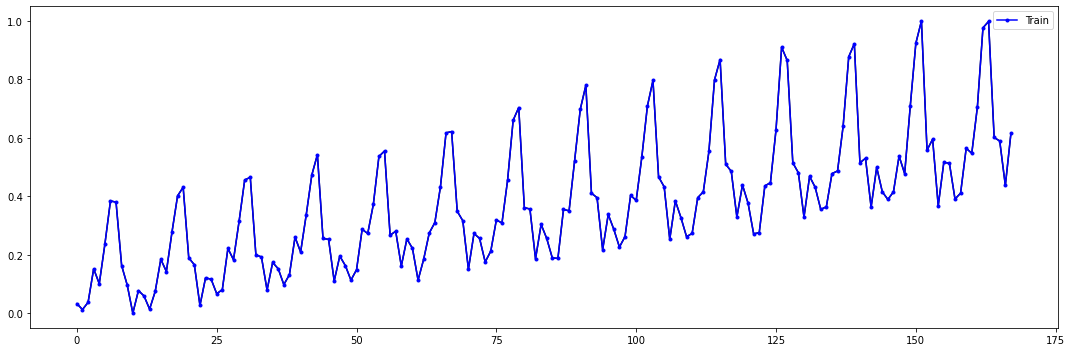

In [3]:
len_F = len(Fort)
fc = 0 # прогноз на _ точек
obs = 150 # прогноз 1 точки по _ прошлым

F = Fort
F = F.reshape(-1, 1) 
scaler = MinMaxScaler(feature_range=(0, 1)) 
F = scaler.fit_transform(F)
F_tr = F[:len_F-fc]
plt.figure(figsize = (15, 5)) 
plt.plot(F, 'k') 
plt.plot(np.r_[:len_F-fc],F_tr, 'b', marker='.',label = 'Train') 
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
data_gen = TimeseriesGenerator(F_tr, F_tr, length=obs, sampling_rate=1, batch_size=len_F-fc)

batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # точки обучения, прогноз 1 точки по _ прошлым 
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #

(18, 150, 1)
(18, 1, 150)
(18, 1)


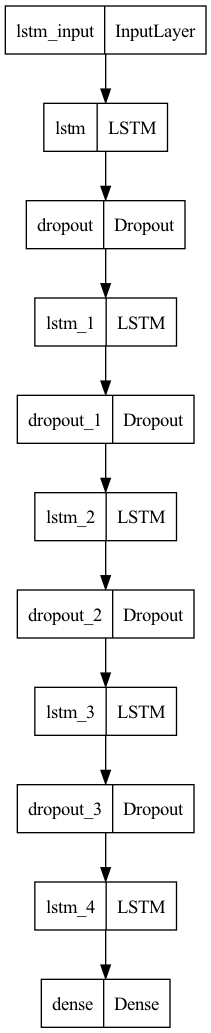

In [280]:
keras.backend.clear_session() 
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(1, obs))) # units нейронов 
model.add(Dropout(0.3)) 
model.add(LSTM(units=100, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=100))
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
plot_model(model, to_file='model.png')

In [281]:
model.fit(xx, yy, epochs = 200) # _ эпох
model.save('lstm_model_2.h5')

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 0.4362
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 0.4303
Epoch 3/200
1/1 [==============================] - 0s 8ms/step - loss: 0.4243
Epoch 4/200
1/1 [==============================] - 0s 9ms/step - loss: 0.4180
Epoch 5/200
1/1 [==============================] - 0s 12ms/step - loss: 0.4113
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 0.4038
Epoch 7/200
1/1 [==============================] - 0s 10ms/step - loss: 0.3955
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 0.3864
Epoch 9/200
1/1 [==============================] - 0s 14ms/step - loss: 0.3762
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 0.3609
Epoch 11/200
1/1 [==============================] - 0s 11ms/step - loss: 0.3481
Epoch 12/200
1/1 [==============================] - 0s 11ms/step - loss: 0.3337
Epoch 13/200
1/1 [==============================] - 0s

In [5]:
from keras.models import load_model
# load model from single file
model = load_model('lstm_model_2.h5')

#### Train and test predict

(18, 150, 1)
(18, 1, 150)
(18, 1)
1/1 [==============================] - 2s 2s/step


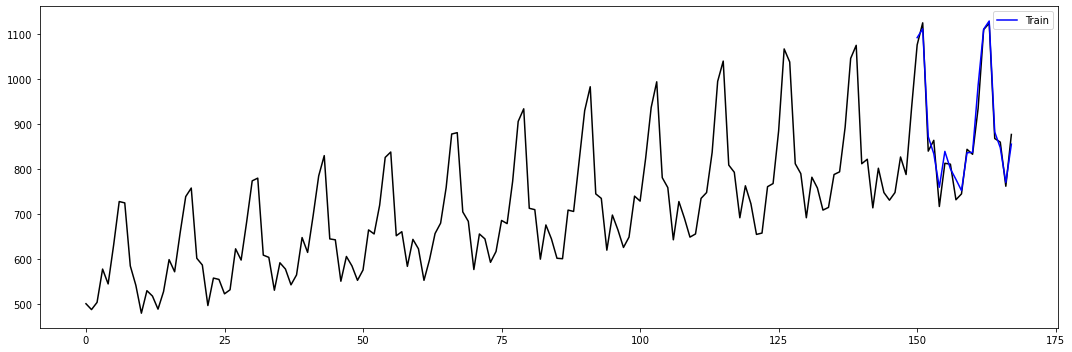

In [6]:
# Train predict
data_gen = TimeseriesGenerator(F_tr, F_tr, length=obs, sampling_rate=1, batch_size=len_F-fc)
batch_0 = data_gen[0]
x, y = batch_0 # вход и обучающий выход для сети
print(x.shape) # точки обучения, прогноз 1 точки по _ прошлым 
xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
yy=y
print(xx.shape) # меняем местами размерности
print(yy.shape) #
trainPredict = model.predict(xx)
trainPredict = scaler.inverse_transform(trainPredict) 
plt.figure(figsize = (15, 5))
plt.plot(Fort, 'k')
plt.plot(np.r_[obs:len_F-fc], trainPredict, 'b', label = 'Train')
plt.legend()
plt.tight_layout()
plt.show()

#### Продлеваем прогноз за грань тестовой части

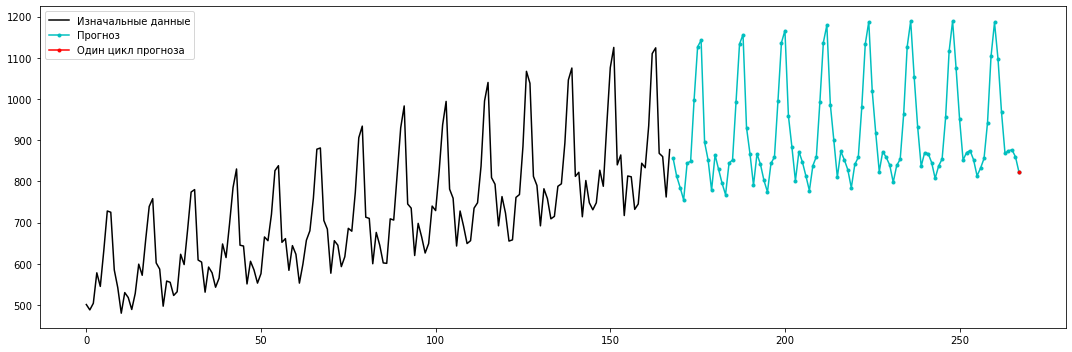

In [9]:
data = Fort
data = data.reshape(-1, 1) 
data = scaler.fit_transform(data)
for i in range(100): # прогноз на _ точек
    data_gen = TimeseriesGenerator(data, data, length=obs, sampling_rate=1, batch_size=len(data)-1, start_index=len(data)-obs-1)
    batch_0 = data_gen[0]
    x, y = batch_0
    xx=np.reshape(x, (x.shape[0], 1, x.shape[1]))
    yy = y
    Predict = model.predict(xx, verbose=0)
    data = np.append(data, Predict)

t1 = np.arange(len(Fort), len(data))
data = data.reshape(-1, 1)
data = scaler.inverse_transform(data)
Predict = scaler.inverse_transform(Predict) 
plt.figure(figsize = (15, 5))
plt.plot(Fort, 'k', label = 'Изначальные данные') 
plt.plot(t1, data[len(Fort):], 'c', marker = '.', label = 'Прогноз') 
plt.plot(t1[-1], Predict, 'r', marker = '.', label = 'Один цикл прогноза')
plt.legend()
plt.tight_layout()
plt.show()

## New one prediction (получился тренд и его прогноз)

In [178]:
# https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
# https://towardsdatascience.com/time-series-prediction-with-lstm-in-tensorflow-42104db39340
# https://stackoverflow.com/questions/69906416/forecast-future-values-with-lstm-in-python
# https://towardsdatascience.com/predicting-future-values-with-rnn-lstm-and-gru-using-pytorch-d9ef50991ec7
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import array
from keras.models import load_model

# return training data
y = Fort
y = y.reshape(-1, 1) 
y = scaler.fit_transform(y)
X = np.arange(len(Fort))
X = X.reshape((len(X), 1, 1))

In [179]:
# define model
keras.backend.clear_session() 
model = Sequential()
model.add(LSTM(units=40, return_sequences=True, input_shape=(1, 1))) # 40 нейронов 
model.add(Dropout(0.3)) 
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40, return_sequences=True)) 
model.add(Dropout(0.3))
model.add(LSTM(units=40))
model.add(Dense(units = 1)) # выход одномерный
model.compile(optimizer = 'adam', loss = 'mean_squared_error') 
# fit model
model.fit(X, y, epochs=140, shuffle=False)
# save model to single file
model.save('lstm_model.h5')

Epoch 1/140
6/6 [==============================] - 7s 10ms/step - loss: 0.1826
Epoch 2/140
6/6 [==============================] - 0s 11ms/step - loss: 0.1669
Epoch 3/140
6/6 [==============================] - 0s 7ms/step - loss: 0.1494
Epoch 4/140
6/6 [==============================] - 0s 6ms/step - loss: 0.1281
Epoch 5/140
6/6 [==============================] - 0s 6ms/step - loss: 0.1014
Epoch 6/140
6/6 [==============================] - 0s 6ms/step - loss: 0.0683
Epoch 7/140
6/6 [==============================] - 0s 10ms/step - loss: 0.0456
Epoch 8/140
6/6 [==============================] - 0s 7ms/step - loss: 0.0500
Epoch 9/140
6/6 [==============================] - 0s 9ms/step - loss: 0.0618
Epoch 10/140
6/6 [==============================] - 0s 8ms/step - loss: 0.0513
Epoch 11/140
6/6 [==============================] - 0s 7ms/step - loss: 0.0439
Epoch 12/140
6/6 [==============================] - 0s 7ms/step - loss: 0.0428
Epoch 13/140
6/6 [==============================] - 0s 7ms

In [301]:
# load model from single file
model = load_model('lstm_model.h5')

# make predictions
yhat0 = model.predict(X)
yhat0 = scaler.inverse_transform(yhat0)

X = np.arange(len(Fort), len(Fort)+50)
X = X.reshape((len(X), 1, 1))
yhat = model.predict(X)
yhat = scaler.inverse_transform(yhat) 

2/2 [==============================] - 0s 4ms/step


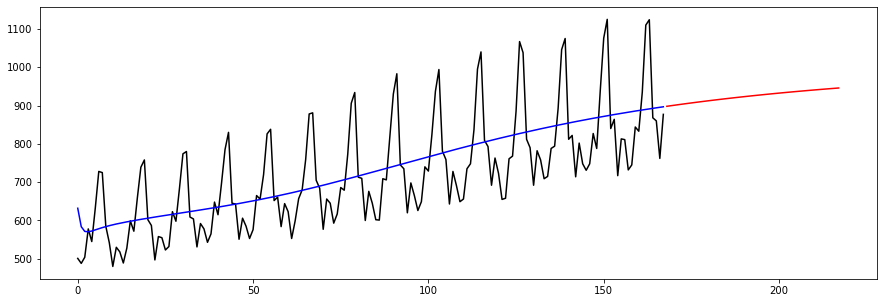

In [302]:
plt.figure(figsize = (15, 5))
plt.plot(Fort, 'k') 
plt.plot(yhat0, 'b')
t = np.arange(len(Fort), len(Fort)+50)
plt.plot(t, yhat, 'r')
plt.show()